In [1]:
# Import Tools
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import ds100_utils

# Import Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import warnings
warnings.filterwarnings("ignore")
import zipfile
import os
from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# Get Data
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()


FileNotFoundError: [Errno 2] No such file or directory: 'cook_county_data.zip'

Here I'll just be making sure that the data is in the right shape.

I'll be using a simple linear model with Sale Price as our regressand. Lets make sure it is here.



In [ ]:

training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
assert training_data.shape == (204792, 62)
assert 'Sale Price' in training_data.columns.values

In [ ]:
# For those interested, run the command below. These are going to be the features we have access to select from that are included in the data.
#training_data.columns

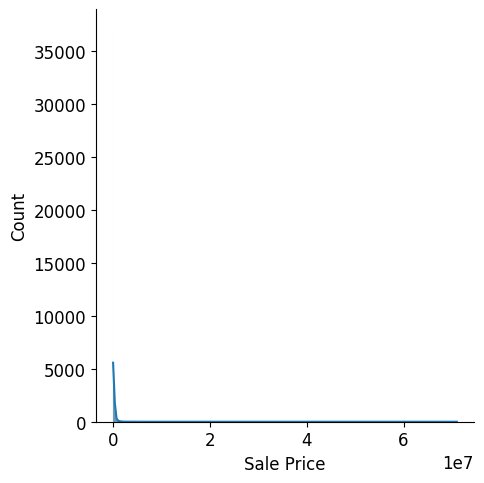

In [ ]:
# Next, I'll start my analysis
label='Sale Price'

sns.displot(data=training_data, x=label, kde=True)

Our visualization seems to be ineffective due to some outliers. Lets investigate the spike around zero.

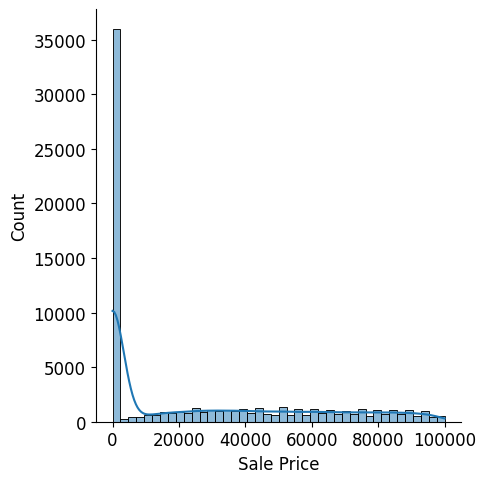

In [ ]:
label='Sale Price'
zoom_in = training_data[training_data['Sale Price'] < 100000 ]
sns.displot(data=zoom_in, x=label, kde=True)

(35568, 305, 125)

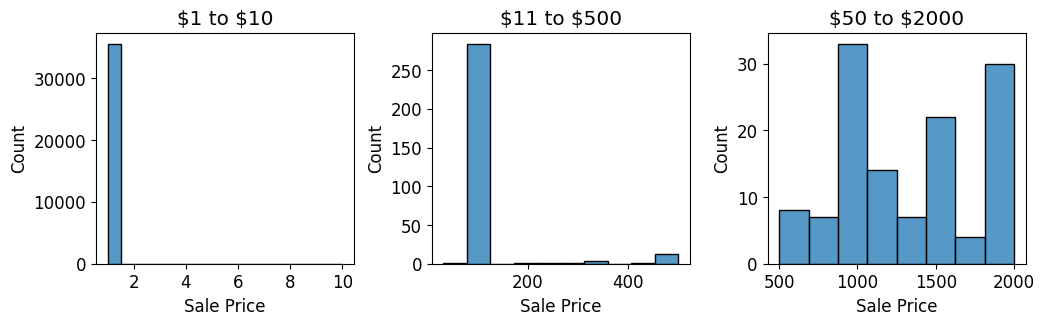

In [ ]:
range_1_10 = training_data[training_data['Sale Price'] <= 10]
range_11_500 = training_data[training_data['Sale Price'] > 10][training_data['Sale Price'] <= 500]
range_500_2000 = training_data[training_data['Sale Price'] > 500][training_data['Sale Price'] <= 2000]

def plot_distribution(data1, data2, data3, label):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3),)
    var =2000
    sns.histplot(data1, x=label, ax=axs[0], kde=False).set_title('\$1 to \$10')
    sns.histplot(data2, x=label, ax=axs[1], kde=False).set_title('\$11 to \$500')
    sns.histplot(data3, x=label, ax=axs[2], kde=False).set_title('\$50 to \$2000')

    plt.subplots_adjust(wspace=.3)

plot_distribution(range_1_10,range_11_500,range_500_2000,label)

#Number of observations in each plot.
len(range_1_10), len(range_11_500), len(range_500_2000)

I've rescaled the y-axis so we can see the relative number of houses in each sub-bin. 
Notice that there are 35568 lots that sold for less than 10 dollars (first plot).  
We'll exclude these, and the 305 other lots that sold for less than 500 dollars (second plot). 
These might be inheritences, transfers of property or some other technicality.

The data in the third sub-bin looks much more plain, and also only have 125 observation, so we'll keep it. 

Lets see what our data looks like after removing the first two sub-bins, and applying a log transform to the the remaining data

<AxesSubplot: xlabel='Log Sale Price', ylabel='Density'>

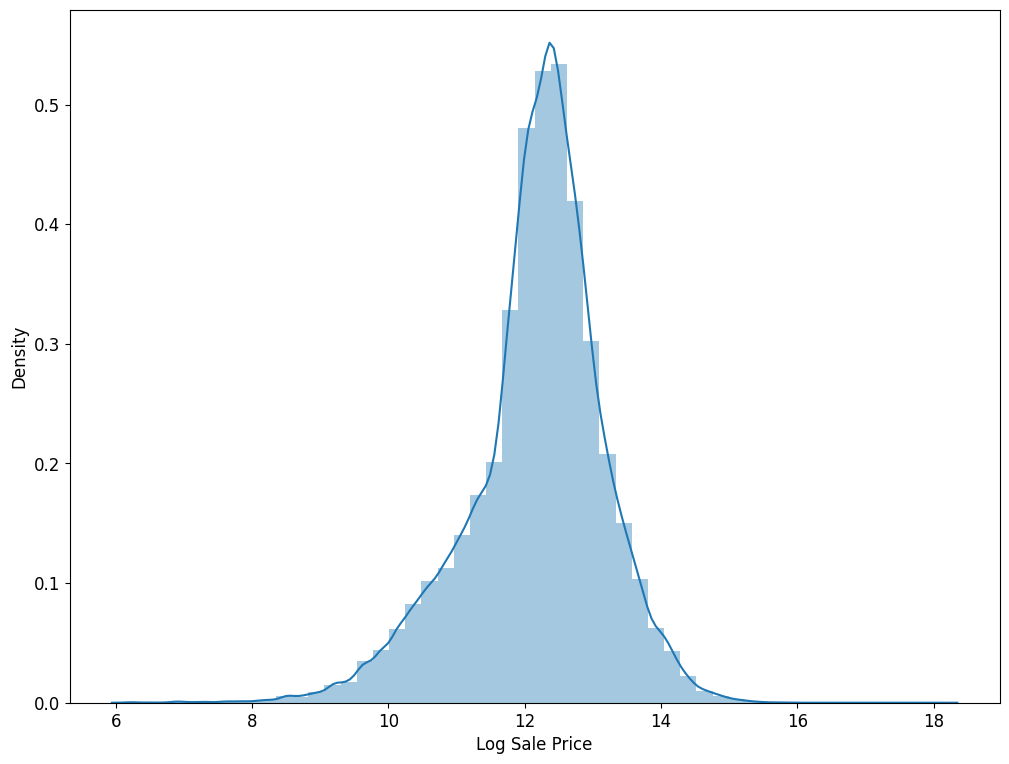

In [ ]:
training_data = training_data.loc[training_data['Sale Price'] >= 500, :]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

sns.distplot(training_data['Log Sale Price'])

In [ ]:
training_data['Log Sale Price'].describe()

count    168931.000000
mean         12.168227
std           0.999586
min           6.214608
25%          11.703546
50%          12.278393
75%          12.765688
max          18.078190
Name: Log Sale Price, dtype: float64

This data looks far more normal and will be much better for working with.

In the future, we might want a different method to remove outliers.

Outliers are usually categorized as anything (1.5 * IQR) above Q3 or below Q1. The IQR is just the range between the 75th and 25th percentiles.
Let's define a function that will help us remove outliers from any feature. The function will set the exclusion length above Q3 to any Distance*IQR, where Distance is set to a defualt of 1.5

In [ ]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[data[variable] <= upper, :].loc[data[variable] >= lower, :]

In [ ]:
def outlier_remover(data, label, dist=1.5):
    q25 = data[label].quantile(.25)
    q75 = data[label].quantile(.75)
    iqr = q75-q25
    lgth= dist*iqr
    lower = q25-lgth
    upper = q75+lgth
    data = data[data[label] < upper][data[label] > lower]

The first metric most people when thinking of the potential price of a house is most likely the lot size. Let's check the correlation between 'Building Square Feet' and 'Sale Price'. Before we do this though, I'll add a column 'Log Building Square Feet'. We might want to do this more than once, so I'll write a function for it.

In [ ]:
def log_adder(data, label):
    string = 'Log ' + label
    data[string] = np.log(training_data[label])

log_adder(training_data, 'Building Square Feet')

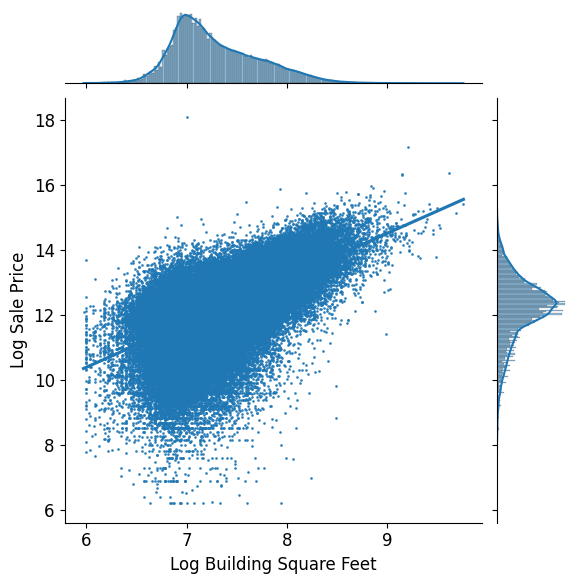

In [ ]:
sns.jointplot(training_data, x='Log Building Square Feet', y='Log Sale Price', kind='reg', scatter_kws={'s': 1})

Next, I'll investigate some other parts of the data and see if we can extract more information. Let's pick an arbitrary data point and read its description. 

In [ ]:
training_data['Description'][69420]

'This property, sold on 01/05/2016, is a one-story houeshold located at 549 FORSYTHE AVE.It has a total of 5 rooms, 3 of which are bedrooms, and 2.0 of which are bathrooms.'

Our data doesn't have a feature for 'number of bedrooms'. However, this information can be found in the description. Let's extract it.

In [ ]:
def add_total_bedrooms(data):
  """
  Input:
    data (data frame): a data frame containing at least the Description column.
  """
  with_rooms = data.copy()
  regex = "rooms, (.*) of which are bedrooms"
  with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(regex).astype(int) 
  return with_rooms

training_data = add_total_bedrooms(training_data)

We can also get the date of the transaction, this might be useful as housing prices tend to go up over long periods of time. 

The regex statemnt used to pull this is: \d{1,2}\/\d{1,2}\/\d{4}

In [ ]:
def add_date(data):
  """
  Input:
    data (data frame): a data frame containing at least the Description column.
  """
  with_date = data.copy()
  regex = "(\d{1,2}\/\d{1,2}\/\d{4})"
  with_date['Date'] = with_date['Description'].str.extract(regex)
  return with_date

training_data = add_date(training_data)

Next, we'll get stories. This will be trickier because the data is given as a string, and we can't be sure they follow the same format.

In [ ]:
def add_stories(data):
  """
  Input:
    data (data frame): a data frame containing at least the Description column.
  """
  with_stories = data.copy()
  regex = "is a\s(\w+)"
  with_stories['Stories'] = with_stories['Description'].str.extract(regex)
  return with_stories

training_data = add_stories(training_data)

In [ ]:
training_data.Stories.unique()

array(['one', 'two', 'three', 'split'], dtype=object)

What is a split-story house?

In [ ]:
training_data[training_data['Stories'] == 'split']['Stories']

training_data['Description'][9120]

'This property, sold on 05/04/2017, is a split-level houeshold located at 1517 ALIMA TER.It has a total of 6 rooms, 4 of which are bedrooms, and 1.0 of which are bathrooms.'

According to the internet:


[<img src="screenshot.png" width="500"/>](screenshot.png)


I'm still not really sure how I should treat stories. Without the split, I could simply numerically encode 'one' 'two or 'three' but 'split' homes make our data more categorical than I would feel comfortable with. 

<AxesSubplot: xlabel='Stories', ylabel='Sale Price'>

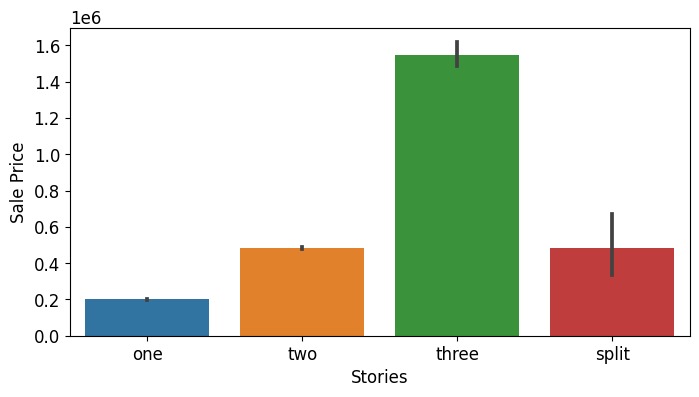

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(data=training_data, x='Stories', y='Sale Price', ax=ax)

I could *naively* use numerical values and encode 'split' as two here. I'll add it to the array, but we can decide if we want to use this later.

In [ ]:
mapping = {
  'one': 1,
  'two': 2,
  'split': 2,
  'three': 3
}

training_data['Number Stories'] = training_data['Stories'].map(mapping)
training_data.loc[:,['Stories', 'Number Stories']]

,Stories,Number Stories
1,one,1
2,one,1
3,one,1
4,one,1
6,one,1
...,...,...
204787,one,1
204788,one,1
204789,one,1
204790,one,1


A 3-story property is probably more likely to be an aprtment complex. There exists a feature called apartments, which ranges from 0 to 6, excluding 1. I'll add a new binary column which specifies if it is an apartment complex or not. If it has zero apartments, it is single family, if it has 2 or more, it is an apartment.

In [ ]:
training_data['Binary Apt'] = training_data['Apartments'].apply(lambda x: 0 if x in [0, 1] else 1)

training_data[training_data['Apartments'] ==5]

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,Date,Stories,Number Stories,Binary Apt
33582,13162030110000,203,60,2825.000000,71,5.0,1.0,1.0,1.0,3.0,...,7160,"This property, sold on 06/06/2018, is a one-st...",2825.000000,12.323856,7.060476,3,06/06/2018,one,1,1
36240,25284170030000,203,250,3577.341533,70,5.0,2.0,1.0,1.0,3.0,...,70250,"This property, sold on 09/05/2013, is a one-st...",3577.341533,9.517825,7.130899,3,09/05/2013,one,1,1
49321,15123200140000,206,40,7425.000000,33,5.0,1.0,1.0,1.0,3.0,...,3340,"This property, sold on 05/18/2018, is a two-st...",7425.000000,12.992255,7.779885,3,05/18/2018,two,2,1
78555,16314220110000,205,70,3488.376096,11,5.0,1.0,1.0,2.0,3.0,...,1170,"This property, sold on 10/30/2013, is a one-st...",3488.376096,9.567665,6.313548,2,10/30/2013,one,1,1
83035,26062230130000,202,100,450.398804,70,5.0,1.0,1.0,2.0,3.0,...,70100,"This property, sold on 05/19/2016, is a one-st...",450.398804,8.958926,6.253829,2,05/19/2016,one,1,1
89666,16314220110000,205,70,3488.376096,11,5.0,1.0,1.0,2.0,3.0,...,1170,"This property, sold on 07/16/2013, is a one-st...",3488.376096,9.597981,6.313548,2,07/16/2013,one,1,1
134622,13301350350000,203,200,7308.000000,71,5.0,1.0,1.0,4.0,3.0,...,71200,"This property, sold on 06/11/2018, is a one-st...",7308.000000,12.524526,7.368340,4,06/11/2018,one,1,1


Lets make a visualization relating Log-Normalized sale prices to number of Bedrooms.

[Text(0.5, 1.0, 'Log Sale Price based on Bedrooms')]

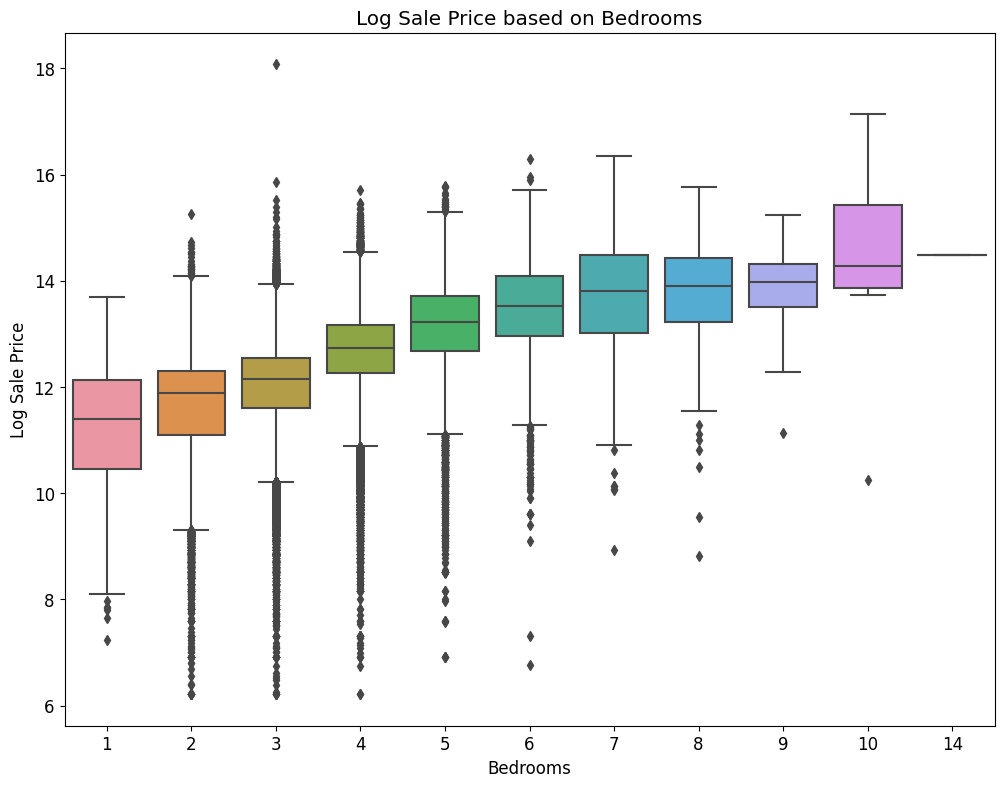

In [ ]:
boxed_up = sns.boxplot(x="Bedrooms", y="Log Sale Price", data=training_data).set(title='Log Sale Price based on Bedrooms')
boxed_up

Now, homes across a town arn't all the same. Some regions have more crime, other regions have agglomertive effects of better scenery, etc etc. We can caputre all these variables, and other variables of this sort in a simple neighborhood code, which already exists in our data.

Here we use a function from the library to help us plot. We'll soon see that it overplots, and that we'll have to fix some stuff.

In [ ]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

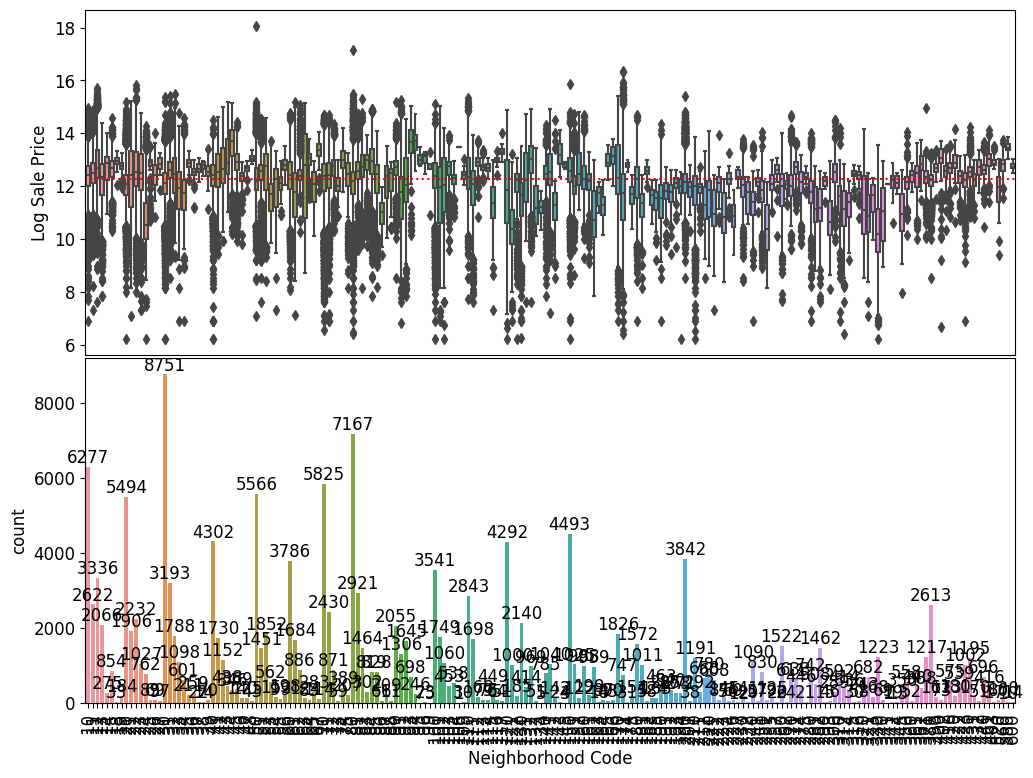

In [ ]:
plot_categorical(training_data)

There are A LOT of neighborhoods. Lets limit them to the 20 with the most number of houses. 

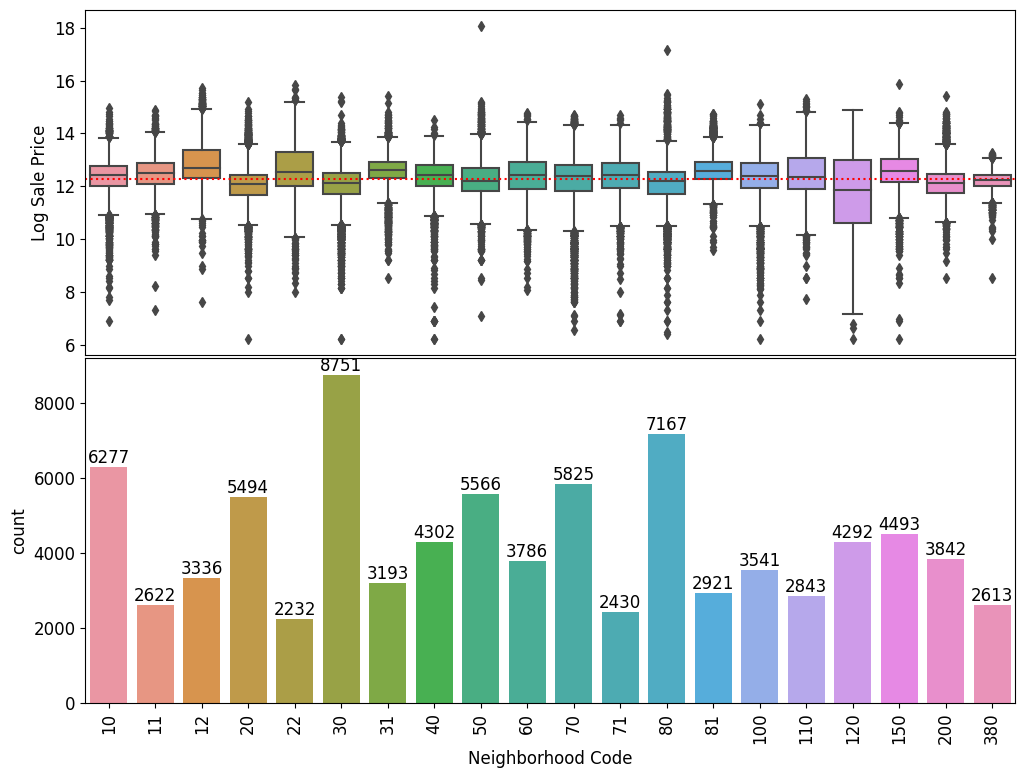

In [ ]:
grouped = training_data.groupby(by = ['Neighborhood Code']).count().sort_values(by= 'PIN', ascending = False).head(20)
array_codes = list(grouped.index)
in_top_20_neighborhoods = training_data.loc[training_data['Neighborhood Code'].isin(array_codes),:]

plot_categorical(neighborhoods=in_top_20_neighborhoods)

Hmm. This wasn't too helpful. There is a weak relationship between the count of properties in an area code and the Log Sale Price, for the most populous 20 neighborhoods. They all seem to share a Log Sale Price of about 12.

I'll take a new approach. Let's seperate out the most rich neighborhoos from the original sample size. I'll write a function that does this for the top n. And then we'll write another function that will add a series of dummy variables. The motivation behind this is that all 'prestigious' living areas will have a similar markup associated with them, as opposed to other living places that will be priced based on fundamentsl already in our dataset. This new series will capture things like social status of a property's ~location~, which is not endogenous to the rest of the data.

In [ ]:
#I iteratively went back and forth between testing a few favlues for n by looking at the different plot shapes. 8 Seems like a good value.
n = 8

def expensive_code(data, n=1, metric=np.median):
    """
    Output: a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    #neighborhoods = data[['Neighborhood Code', 'Log Sale Price']].groupby(by = ['Neighborhood Code']).agg(metric).head(n)
    
    neighborhoods = data[['Neighborhood Code', 'Log Sale Price']]\
.groupby(by = ['Neighborhood Code']).agg(metric).sort_values('Log Sale Price', ascending = False).head(n).index
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

exp_codes = expensive_code(training_data, n, np.median)
'the top neighborhood codes are ' + str(exp_codes)

'the top neighborhood codes are [44, 94, 93, 106, 580, 67, 117, 143]'

Next, I'll write a manual dummy variable function for this feature. Right after, I then use an automatic dummy variable creator, just in case I need to add in more complexity.

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

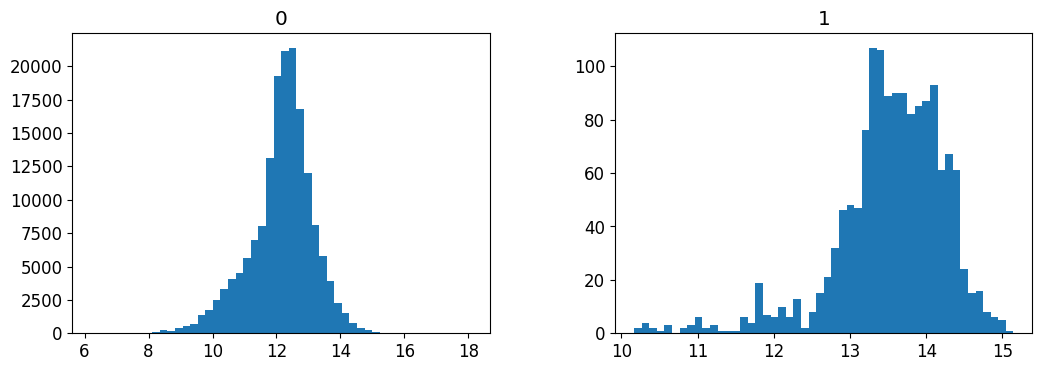

In [ ]:
def dummy_expensive(data, neighborhoods):
    """
    Output: data frame identical to the input with the addition of a binary in_expensive_neighborhood column
    """
    data['dummy_expensive'] = data['Neighborhood Code'].isin(neighborhoods).astype(int)
    return data

expensive_neighborhoods = expensive_code(training_data, n, np.median)
training_data = dummy_expensive(training_data, expensive_neighborhoods)

training_data.hist('Log Sale Price', by='dummy_expensive', bins=50, figsize=(12,4), xrot=0)

I'll make a few more dummy variables here.

In [ ]:
from sklearn.preprocessing import OneHotEncoder


def substitute_roof_material(data):
    data['Roof Material'] = data['Roof Material'].replace(to_replace = [1,2,3,4,5,6], value = ['Shingle/Asphalt', 'Tar&Gravel', 'Slate', 'Shake', 'Tile', 'Other'])
    return data
    

def create_dummy_variables(df, column):
    """
    Given a pandas DataFrame and a specified column, adds dummy variable columns based on the unique
    categorical values in the input column using pandas' get_dummies() function. Returns the modified
    DataFrame.
    """
    dummy_cols = [column + '_' + str(val) for val in df[column].unique()]
    if set(dummy_cols).issubset(set(df.columns)):
        # Dummy variable columns already exist, return original data frame
        return df
    else:
        # Dummy variable columns do not exist, create them using get_dummies()
        dummy_df = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummy_df], axis=1)
        return df


In [ ]:
training_data = substitute_roof_material(training_data)
training_data = create_dummy_variables(training_data, 'Roof Material')

training_data.iloc[:,-15:].head(5)


,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,Date,Stories,Number Stories,Binary Apt,dummy_expensive,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,3780.0,12.560244,6.904751,3,05/23/2018,one,1,0,0,0,0,1,0,0,0
2,4375.0,9.998798,6.810142,3,02/18/2016,one,1,0,0,0,0,1,0,0,0
3,4375.0,12.323856,7.068172,3,07/23/2013,one,1,0,0,0,0,1,0,0,0
4,8400.0,10.025705,6.855409,2,06/10/2016,one,1,0,0,0,0,1,0,0,0
6,10890.0,11.512925,7.458186,4,10/26/2017,one,1,0,0,0,0,1,0,0,0


Above, we can see all 15 new variables added. 
Just a few reminders while we are here. 

1) Stories are categorical, because it includes split homes. Number Stories is numerical, as split homes have been encoded as apartments with 2 stories. 

2) There exists a feature called apartments, which ranges from 0 to 6, excluding 1. I've created a binary varible based off this. This is important, because apartments are investment vehicles far more than single family homes. (Obvious, but citation needed)

3) The dummy variable for an expensive neighborhood is based off the top n neighborhoods. n can be respecified at any time. 

Part 1 of the project ended here. Next is part 2 of the project.

In [ ]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

In [ ]:
#pre-built data splitting functions

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    train_indices = shuffled_indices[:int(data_len*.8)]
    test_indices = shuffled_indices[int(data_len*.8):]
    
    train = data.iloc[list(train_indices)]
    test = data.iloc[list(test_indices)] 
    return train, test
    
train, test = train_test_split(training_data)

from feature_func import *    
# imports functions from Project 1A
# run this cell to define process_data_gm and select_columns

def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

def sqyare(data, col):
    data[col + '_sq'] = (data[col])**2
    return data 

What's the idea here?

We don't want to overfit our model to all the data, so we create a training and testing split. We want to split the data randomly, which isn't too hard in this context (Something like creating test/train in a time series context would be much harder).

We use to do this using 'train_test_split()'. We also use 'm1_pipelines[]' passed into 'process_data_gm()' to specify all the transformations and features that we will eventually be training on.

M1 and M2 signify either model1 or model2. I've dont this to show the improvment in accuracy when more fetaures are added

In [ ]:
# This makes the train-test split in this section reproducible across different runs of the notebook.
#SET SEED
np.random.seed(1337)


# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# create the training and testing data
train_m1, test_m1 = train_test_split(full_data)

# Process the data using the pipeline for the first model
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]



X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_test_m1, y_test_m1 = process_data_gm(test_m1, m1_pipelines, 'Log Sale Price')

In [ ]:
train_m2, test_m2 = train_test_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col' : 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)

]

X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_test_m2, y_test_m2 = process_data_gm(test_m2, m2_pipelines, 'Log Sale Price')

Create the lm objects and fit them as models.

In [ ]:
from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [ ]:
# Fit the 1st model
# Compute the fitted and predicted values of Log Sale Price for 1st model

linear_model_m1.fit(X_train_m1, y_train_m1)
y_fitted_m1 = linear_model_m1.predict(X_train_m1)

y_predicted_m1 = linear_model_m1.predict(X_test_m1)

# Fit the 2nd model
# Compute the fitted and predicted values of Log Sale Price for 2nd model


linear_model_m2.fit(X_train_m2, y_train_m2)
y_fitted_m2 = linear_model_m2.predict(X_train_m2)

y_predicted_m2 = linear_model_m2.predict(X_test_m2)

What is the RMSE? This is the root, mean, squared error. 

To understand what this is, we start with the first operation. Inside the summation is the sum of the squared errors. We do this because the model will have errors in the positive and negative direction, and they will sum to zero, which isn't useful. So we square them to get a good understaning of the magnitude of the errors. 

We then divide by n, to get a measure that is proportional to the size of data points in the model. 

Finally, this measure is 'rooted' to revert to a measure that is comparable to the original prediction errors. Another useful measure is the MAE, or the mean absolute error, which involves taking the absolute value of errors. I will not discuss this further, but there is interesting literature on it. [Mean Absolute Error (MAE)](https://www.jstor.org/stable/24869236)

$$RMSE = \sqrt{\frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{n}} = \sqrt{\frac{\sum_{houses}(price_{actual} - price_{pred})^2}{num houses}}$$

In [ ]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [ ]:
# Training and test errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
test_error_m1 = rmse(y_predicted_m1, y_test_m1)

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1), np.exp(y_train_m1))
test_error_m1_delog = rmse(np.exp(y_predicted_m1), np.exp(y_test_m1))


# Training and test errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
test_error_m2 = rmse(y_predicted_m2, y_test_m2)


# Training and test errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.exp(y_fitted_m2), np.exp(y_train_m2))
test_error_m2_delog = rmse(np.exp(y_predicted_m2), np.exp(y_test_m2))

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1_delog, test_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2, test_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2_delog, test_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699077
Test RMSE: 0.9068644732045885

1st Model (no log transform)
Training RMSE: 382697.7814971628
Test RMSE: 310679.2486611497

2nd Model
Training RMSE: 0.804994055826397
Test RMSE: 0.8082661410733806

2nd Model (no log transform)
Training RMSE: 324364.17089418834
Test RMSE: 261007.58352310534



Wow, the log transform is important!

In [ ]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ0: {}\nθ1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ0: {}\nθ1: {}\nθ2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ0: 10.571725401038162
θ1: 0.4969197463147423
2nd Model
θ0: 1.965028271903165
θ1: -0.027346383947300063
θ2: 1.4114620469695827


As we can see, each theta decreases. This makes sense because with more features, each feature accounts for less of the prediction. But why does one coefficient flip signs? This can be answered by the fact that the Bedrooms and Log Building Square Feet might be colinear. If two variables are positively correlated, then adding both features could result in one of them turning negative. Not only are the two features interacting with the prediction, but they are now interacting with each other.

Footnotes/Research: Stack Excahnge and Wikipedia

In [ ]:
np.exp(.496), np.exp(-0.02)

(1.6421395578187052, 0.9801986733067553)

Interperetation:

In the first model, a 1 unit increase in total bedrooms leads to approximately 0.5 increase in log sale price

In the second model, a 1 unit increase in total bedrooms leads to a approximately .026 decrease in log sale price and a 1 unit increase in log building square feet leads to a 1.413 unit increase in log sale price.

Our θ_0's in both models are not really interperetable in this case due to the fact that it would make no sense for a home to have no bedrooms or a square feet of zero, but we can just think about θ_0 as a starting point for the model, which bedrooms and additional square feet add aditional log sale price to.

//

Another thing to think about is that relationships between logged variables. Changes in logs can sometimes be thought of as percentage changes.
In model1, a 1 unit increase in total bedrooms leads to approximately 64% in sale price. This is because e^(.496) = 1.64. 

In model2, a 1 unit increase in total bedrooms leads to approximately 2% decrease in sale price. +1% in square feet leads to +1.4% increase in sale price.

Next, I show the regression surface for model2. We can see that it is no where near perfect.

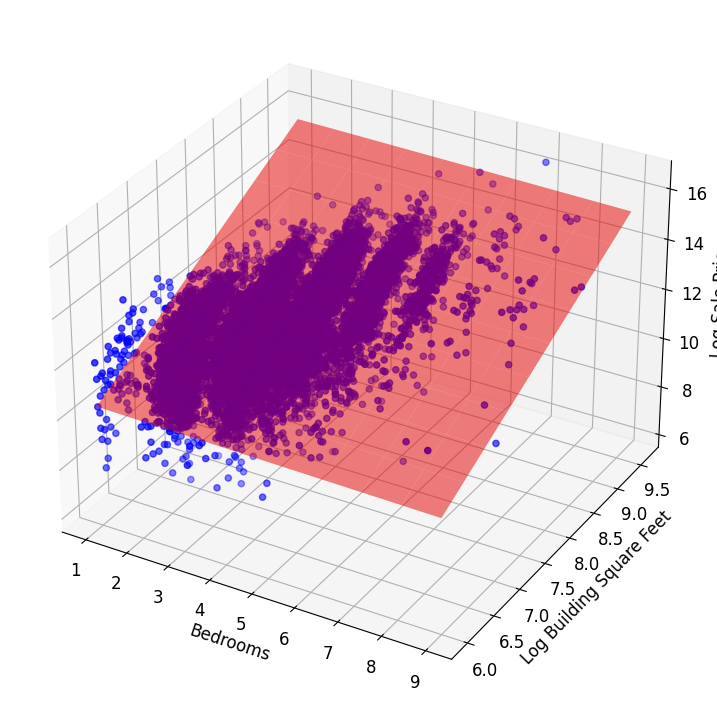

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Extract x and y coordinates from X
x_coords = X_test_m2[:, 0]
y_coords = X_test_m2[:, 1]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of x, y, and z coordinates
ax.scatter(x_coords, y_coords, y_test_m2, c='blue')

# Set labels
ax.set_xlabel('Bedrooms')
ax.set_ylabel('Log Building Square Feet')
ax.set_zlabel('Log Sale Price')

# Regression coefficients
θ0 = 1.947499901719329
θ1 = -0.026579307894893035
θ2 = 1.41340531691632

# Generate a grid of points for the plane
x_grid, y_grid = np.meshgrid(np.linspace(x_coords.min(), x_coords.max(), 10),
                             np.linspace(y_coords.min(), y_coords.max(), 10))

# Compute z-values for the plane
z_grid = θ1 * x_grid + θ2 * y_grid + θ0

# Plot the regression plane
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, color='red')

# Show the plot
plt.show()


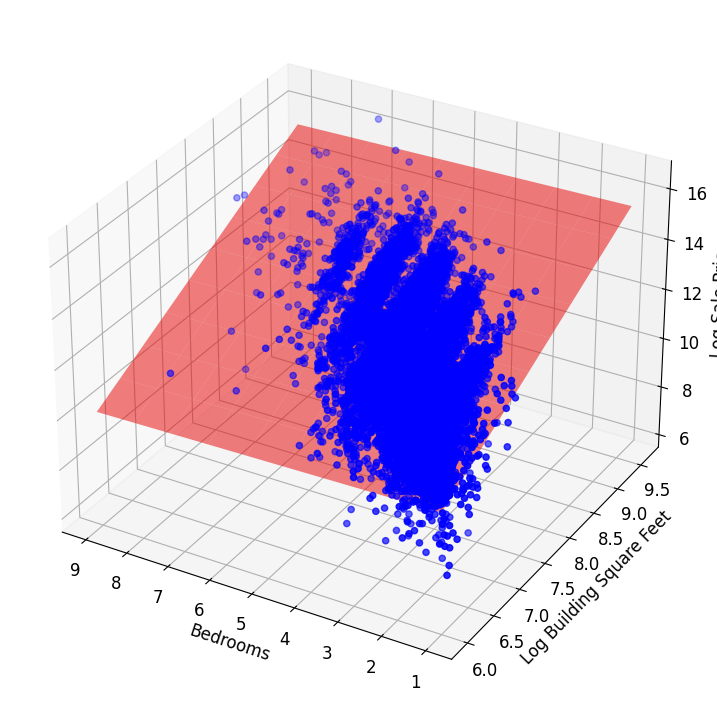

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Extract x and y coordinates from X
x_coords = X_test_m2[:, 0]
y_coords = X_test_m2[:, 1]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of x, y, and z coordinates
ax.scatter(x_coords, y_coords, y_test_m2, c='blue')

# Set labels
ax.set_xlabel('Bedrooms')
ax.set_ylabel('Log Building Square Feet')
ax.set_zlabel('Log Sale Price')

# Regression coefficients
θ0 = 1.947499901719329
θ1 = -0.026579307894893035
θ2 = 1.41340531691632

# Generate a grid of points for the plane
x_grid, y_grid = np.meshgrid(np.linspace(x_coords.min(), x_coords.max(), 10),
                             np.linspace(y_coords.min(), y_coords.max(), 10))

# Compute z-values for the plane
z_grid = θ1 * x_grid + θ2 * y_grid + θ0

# Plot the regression plane
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, color='red')

# Invert the x-axis
ax.invert_xaxis()

# Set custom tick labels for the inverted x-axis
#ax.set_xticklabels(ax.get_xticks()[::1])

# Show the plot
plt.show()


We can even check out errors to see if our homoskedasticity assumption is violated.

Text(0.5, 1.0, 'Errors v. Log Sale Price')

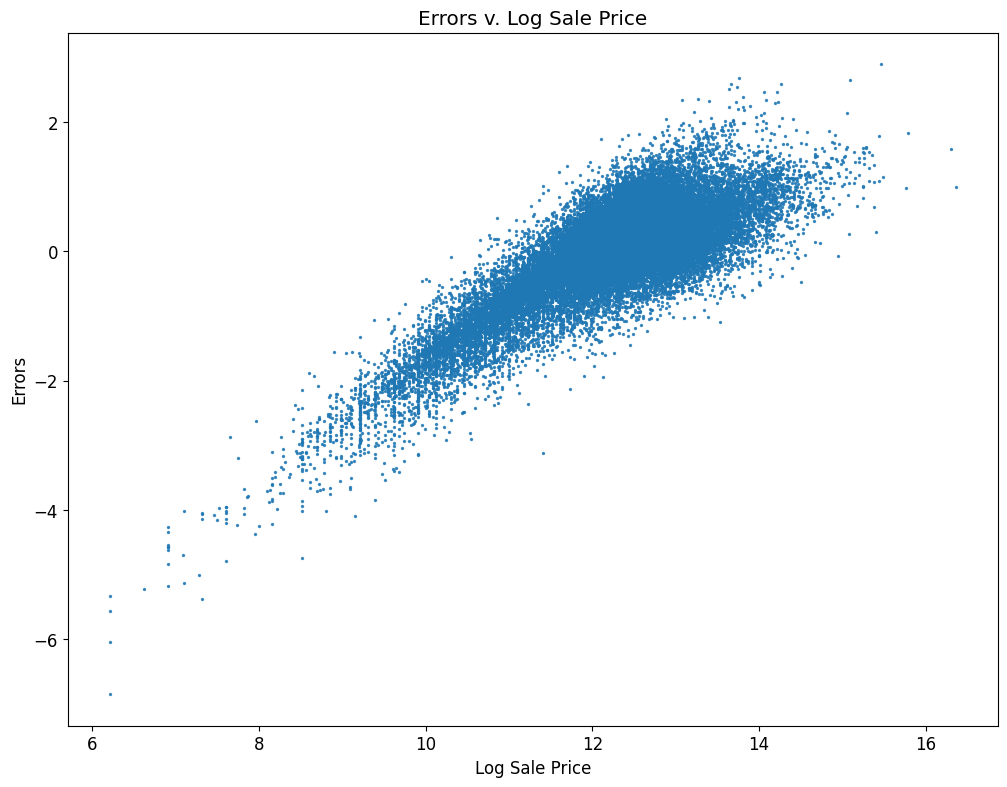

In [ ]:
plt.scatter(x=y_test_m2, y=y_test_m2 - y_predicted_m2, s=2, alpha=.8)
plt.xlabel('Log Sale Price')
plt.ylabel('Errors')
plt.title('Errors v. Log Sale Price')

If we used our current model to price properties, we would end up with a regressive tax system, where more expensive houses are systematically undervalued (underpredicted, positive errors) and cheaper houses are overtaxed (overpredicted, negative errors)

Time to make a more advanced model with many predictors.

In [ ]:
# Define any additional helper functions you need here

def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_bedrooms = data.copy()
    regex1 = "(\d) * of which are bedrooms"
    with_bedrooms['Bedrooms'] = (with_bedrooms['Description'].str.extract(regex1)).astype(int)
    return with_bedrooms

def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_bathrooms = data.copy()
    regex2 = "(\d) * of which are bathrooms"
    with_bathrooms['Bathrooms'] = (with_bathrooms['Description'].str.extract(regex2)).astype(int)
    return with_bathrooms

def add_total_rooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms['Total Rooms'] = (with_rooms['Description'].str.extract("(\d) rooms,")).astype(int)
    return with_rooms

def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    data['Roof Material'] = data['Roof Material'].replace(to_replace = [1,2,3,4,5,6], value = ['Shingle/Asphalt', 'Tar&Gravel', 'Slate', 'Shake', 'Tile', 'Other'])
    return data

def one_hot_encoding(data, feature):
    """
    One-hot-encodes specified feature from data-table.  New columns are of the form x0_FEATURE.
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    X = data[[feature]]
    enc.fit(X)
    enc.get_feature_names(['x0'])
    data[enc.get_feature_names(['x0'])] = enc.transform(X).toarray()
    return data

#Normalize all 62 columns, create a covariance table for all of them 

# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.

    
def process_data_fm(data, is_test_set=False):

    if not is_test_set:
        data = remove_outliers(data, variable = 'Sale Price', lower = 499, upper =  1000000)
        data = remove_outliers(data, variable = 'Number of Commercial Units', upper = 1)
        data = remove_outliers(data, variable = 'Estimate (Land)', lower = 1)
        data = remove_outliers(data, variable = 'Estimate (Building)', lower = 1)
        data['Log Sale Price'] = np.log(data['Sale Price'])
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    data['Root Building Square Feet'] = np.sqrt(data['Building Square Feet'])
    data['Log Estimate (Land)'] = np.log(data['Estimate (Land)'])
    data['Root Estimate (Land)'] = np.sqrt(data['Estimate (Land)'])
    data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'])
    data['Root Estimate (Building)'] = np.sqrt(data['Estimate (Building)'])
    data['Log Land Square Feet'] = np.log(data['Land Square Feet'])
    data['Root Land Square Feet'] = np.sqrt(data['Land Square Feet'])
    data = add_total_rooms(data)
    
    if not is_test_set:
        data = select_columns(data, 'Log Sale Price', 
                              'Log Building Square Feet', 
                              'Root Building Square Feet', 
                              'Log Estimate (Land)', 
                              'Root Estimate (Land)', 
                              'Log Estimate (Building)',
                              'Root Estimate (Building)', 
                              'Log Land Square Feet', 
                              'Root Land Square Feet', 
                              'Total Rooms', 
                              'Number of Commercial Units')
    else:
        data = select_columns(data, 
                              'Log Building Square Feet', 
                              'Root Building Square Feet', 
                              'Log Estimate (Land)', 
                              'Root Estimate (Land)', 
                              'Log Estimate (Building)',
                              'Root Estimate (Building)', 
                              'Log Land Square Feet', 
                              'Root Land Square Feet', 
                              'Total Rooms', 
                              'Number of Commercial Units')

    data = data.fillna(0)
    data.replace([np.inf, -np.inf], 0, inplace=True)
  
    # Return predictors and response variables separately
    X = data
    if is_test_set:
        return X
    else:
        X = data.drop(['Log Sale Price'], axis = 1)
        y = data.loc[:, 'Log Sale Price']
        return X, y

training_data = pd.read_csv('cook_county_train.csv')
process_data_fm(training_data)

(        Log Building Square Feet  Root Building Square Feet  \
 1                       6.904751                  31.575307   
 2                       6.810142                  30.116441   
 3                       7.068172                  34.263683   
 4                       6.855409                  30.805844   
 6                       7.458186                  41.641326   
 ...                          ...                        ...   
 204787                  6.813445                  30.166206   
 204788                  7.603399                  44.777226   
 204789                  6.815640                  30.199338   
 204790                  7.092574                  34.684290   
 204791                  6.946976                  32.249031   
 
         Log Estimate (Land)  Root Estimate (Land)  Log Estimate (Building)  \
 1                 10.802429            221.675438                12.086726   
 2                 10.175421            162.018517                11.058

Next, the predictions are made and a csv file with errors are outputted

In [ ]:
from datetime import datetime

# Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_fm, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
#                                          is_test = True, is_ranking = False, return_predictions = True
#                                          )

# # Construct and save the submission:
# submission_df = pd.DataFrame({
#     "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
#     "Value": Y_test_pred,
# }, columns=['Id', 'Value'])
# timestamp = datetime.isoformat(datetime.now()).split(".")[0]
# submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

# print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
# print('You may now upload this CSV file to Gradescope for scoring.')

Conclusion:

In the context of estimating the value of houses, what does error mean for an individual homeowner? How does it affect them in terms of property taxes?

The RMSE is basically the standard deviation of residuals. It basically gives an idea of how variable the data is from the mean. It is also in the same units as the mean, because we have taken the 'root' of the 'squared errors'. What this means for taxpayers is that they can now expect to have their house be a few SD's away from the prediction with high probability. In other words, when they look at the prediction and RMSE, they can reasonably assume that their house will be not too far from the prediction +/- the RMSE. Calculating a small RMSE gives the residents stronger conviction about the predictions. This could help gain more trust in the model amongst the citizenry, as the market value will not be too different from the assesment value for taxes.

How should we think about 'fairness'?

I would think of fairness in the assessment of propery taxes as having a progressive tax system. This would mean that cheaper houses should be slightly under-assesed while more expensive houses would be slightly over-assesed. A system of this sort could help aleviate income inequality and bring in more tax revenue.(1) The reason that I belive that this is 'fair' is that I think it helps optimize society to be more productive. People in lower income brackets would need to worry about their tax liability less and could focus on developing skills for the 21-st century economy (science, tech, etc)(2).

Richer people in more expensive houses (more expensive neighborhoods) are almost unarguably better protect by the law.(3) We can think of this of this as a service that the governement provides them, for a proportionally higher fee (taxes). By thinking about things this way, we can reasonably call a progressive tax system fair. 

(1) A speculative guess is that this would also bring in more tax revenue, but this might be untrue. Check research on Laffer Curve effects in county real estate data. After a double check, I am suprised that little research exists on this, possibly a senior thesis topic.

(2) Current skilled-labor shortage in America, firms are hiring like crazy. (Written in 2022, this ages poorly lol)

(3) https://housingmatters.urban.org/research-summary/neighborhoods-gentrify-police-presence-increases